# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

In [31]:
#Подгружаю необходимые библиотеки
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
import warnings
warnings.filterwarnings("ignore")

In [32]:
train=pd.read_csv('/datasets/gold_recovery_train.csv',parse_dates = ['date']) #обучающая выборка
test=pd.read_csv('/datasets/gold_recovery_test.csv',parse_dates = ['date']) # тестовая выборка
full=pd.read_csv('/datasets/gold_recovery_full.csv',parse_dates = ['date']) # исходные данные

Посмотрим какие признаки есть в трейне, но нет в тесте

In [33]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тесте у нас нет признаков output, так как это целевые признаки.

Так же в тесте нет признаков calculation для этапа rougher, видимо эти данные рассчитываются позднее и не доступны во время процесса.
Проверим расчет recovery в train:

- Вычислим recovery из сырых значений, проверим сколько из них совпало с предоставленными
- Вычислим MAE для рассчитанных значений и исходых

### 1.2. Проверька правильности расчета эффективности обогащения

In [34]:
def calc_recovery(C, F, T):
    
    numerator = (C*(F-T))
    denominator =(F*(C-T))
    
    rec = numerator / denominator * 100
    
    # так как мы не застрахованы от очень больших и очень маленьких значений, то заполним их
    rec[rec<0] = np.nan
    rec[rec>100] = np.nan
    return rec

In [35]:
recovery=train.dropna().reset_index()
rougher_output_recovery=recovery['rougher.output.recovery']
rougher_output_tail_au=recovery['rougher.output.tail_au']
rougher_input_feed_au=recovery['rougher.input.feed_au']
rougher_output_concentrate_au=recovery['rougher.output.concentrate_au']

In [36]:
rec = calc_recovery(rougher_output_concentrate_au,rougher_input_feed_au,rougher_output_tail_au)
rec

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
11012    89.574376
11013    87.724007
11014    88.890579
11015    89.858126
11016    89.514960
Length: 11017, dtype: float64

In [37]:
def show_na(df):
    na_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    return res


show_na(train).head(10)

,percent,abs
rougher.output.recovery,0.152610,2573
rougher.output.tail_ag,0.133452,2250
rougher.output.tail_sol,0.133393,2249
rougher.output.tail_au,0.133393,2249
secondary_cleaner.output.tail_sol,0.117794,1986
rougher.input.floatbank11_xanthate,0.112930,1904
final.output.recovery,0.090214,1521
primary_cleaner.input.sulfate,0.077521,1307
primary_cleaner.input.depressant,0.074852,1262
rougher.calculation.au_pb_ratio,0.073665,1242


##### Метрика MAE для проверки расчетного значения rougher_output_recovery и табличного

In [38]:
mean_absolute_error(rec,rougher_output_recovery)

9.555596961987514e-15

In [39]:
rec.isna().sum()

0

Пропуски в тесте не значительны

В целом можно сказать, что значения посчитаны верно. Были значения >100 и <0. Эти значения и сделали ошибку.

### 1.3 Предобработка

In [40]:
train[train['final.output.concentrate_pb'].isna()].head(5) # Смотрим припуски. Их много.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
746,2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1310,2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311,2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,2016-03-09 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930,2016-04-04 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
# Поэтому заполняем последним действительным значением вперед
full=full.fillna(method='ffill')
train=train.fillna(method='ffill')

In [42]:
full[full['final.output.concentrate_ag'].isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


# 2. Анализ данных

Построим распределения концентраций металов на выходе каждого процесса и в хвостах

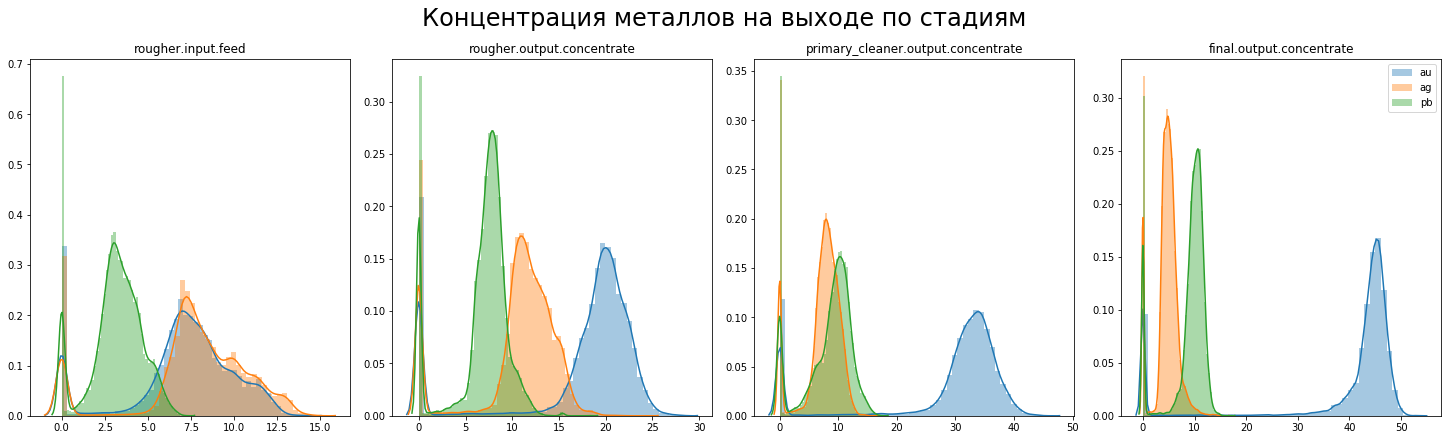

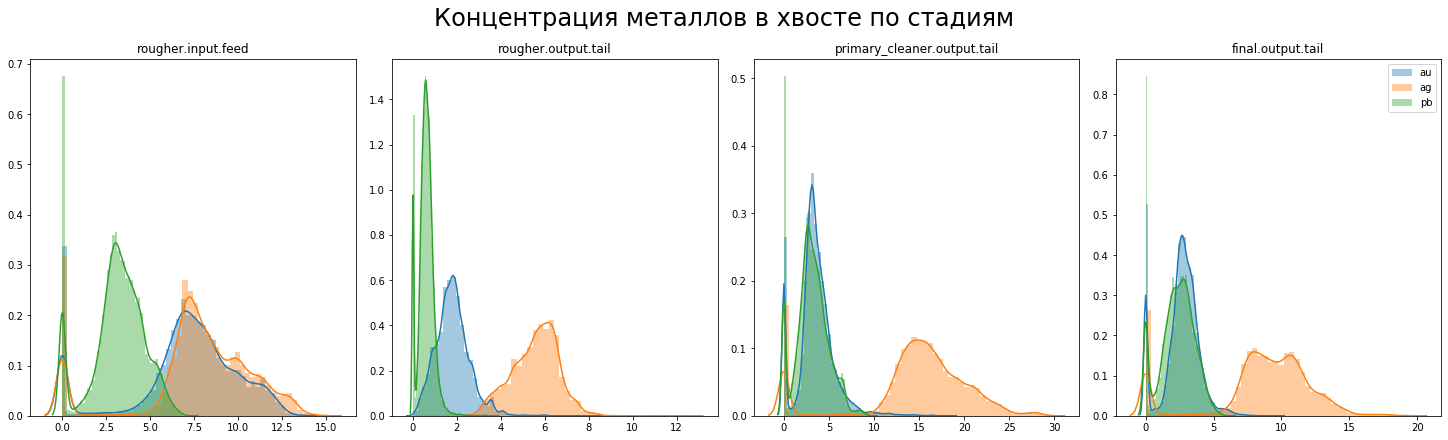

In [43]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе по стадиям', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвосте по стадиям', fontsize=24)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

1) Из графиков видно что в процессе очистики концентрация золота возрастает, отметим достаточно большое количетсво нулевых значений

2) Так же отмети различную концентрацию металлов в хвостовых отвалах в после различных этапов

3) Дополнительно посторим графики для концентрации кадого металла на разны процессах на выходе и в хвосте

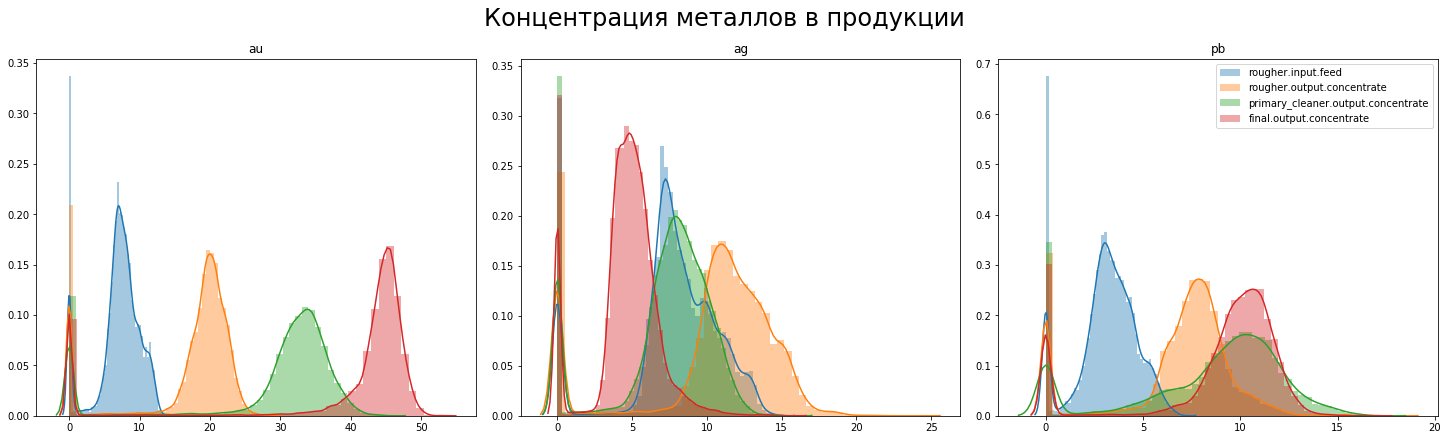

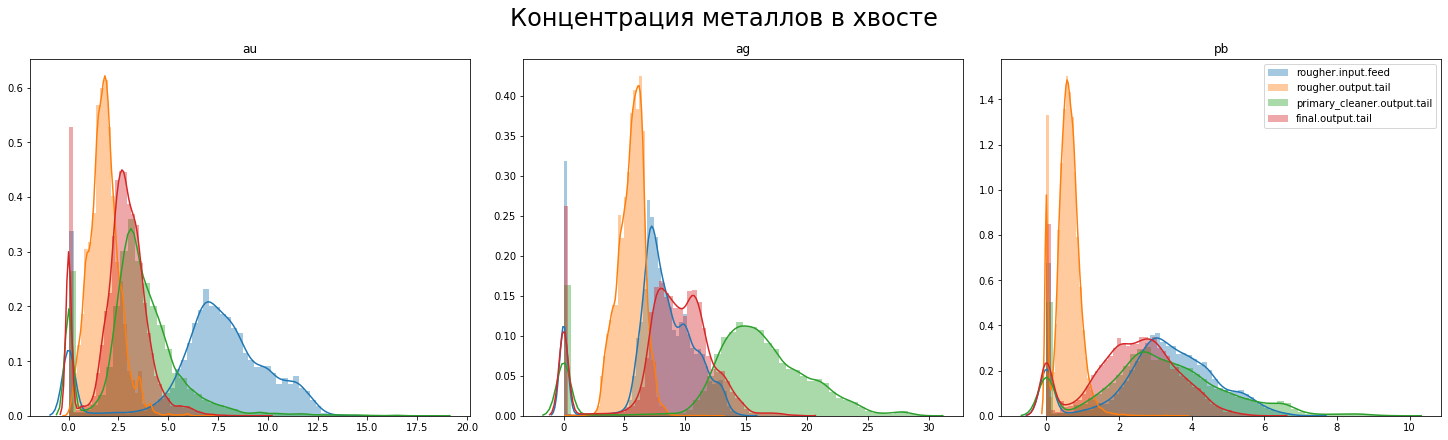

In [44]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в продукции', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвосте', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Отметим, что концентрация золота по мере очистки значительно вырастает, так же вырастают концентрации серебра и свинца, но не так значительно.

Самая большая концентрация золота в хвостах после флотации, при очистке концентрация золота в хвоствх чуть меньше. Тоже самое характерно для других металлов.

Проверим размер гранул сырья в трейне и в тесте

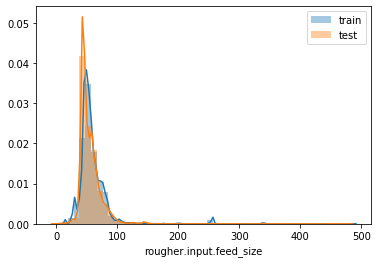

In [45]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

- Как мы видим распределения очень похожи
- Исследуем суммарню концерацию в разных процессах в трейне и в тесте


### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [46]:
# Считаю сумму концентраций металлов после флотации
full['sum_concentrate_rougher']=full['rougher.output.concentrate_ag']+full['rougher.output.concentrate_pb']+full['rougher.output.concentrate_sol']+full['rougher.output.concentrate_au']

# Считаю сумму концентраций металлов после первичной очистки
full['sum_primary_cleaner_output_concentrate']=full['primary_cleaner.output.concentrate_ag']+full['primary_cleaner.output.concentrate_pb']+full['primary_cleaner.output.concentrate_sol']+full['primary_cleaner.output.concentrate_au']

# Считаю сумму концентраций металлов после финальной очистки
full['sum_final_output_concentrate']=full['final.output.concentrate_ag']+full['final.output.concentrate_pb']+full['final.output.concentrate_sol']+full['final.output.concentrate_au']

sum_concentrate=['sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate']

Text(0, 0.5, 'Частота')

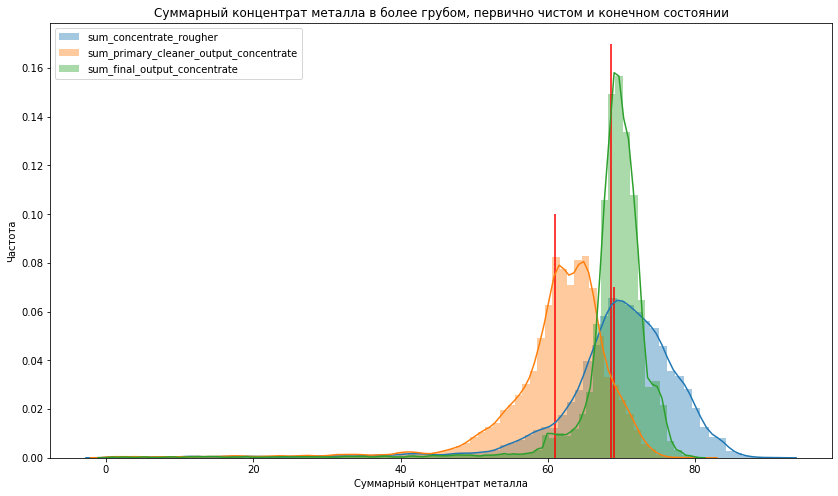

In [47]:
plt.figure(figsize=(14,8))
sns.distplot(full[full['sum_concentrate_rougher']>0.04]['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(full[full['sum_primary_cleaner_output_concentrate']>0.04]['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(full[full['sum_final_output_concentrate']>0.04]['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(full[full['sum_concentrate_rougher']>0.3]['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(full[full['sum_primary_cleaner_output_concentrate']>0.3]['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(full[full['sum_final_output_concentrate']>0.3]['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Суммарный концентрат металла в более грубом, первично чистом и конечном состоянии')
plt.xlabel("Суммарный концентрат металла")
plt.ylabel("Частота")


По распределению видно, что присутствуют выбросы. Есть много значению от 0 до 40, которые можно удалить. их очень много,а чистота их нулевая. Поэтому, думаю можно их удалить, чтобы не мешали обучению модели.

In [48]:
full=full[full['sum_final_output_concentrate']>40]
full=full[full['sum_primary_cleaner_output_concentrate']>40]
full=full[full['sum_concentrate_rougher']>40]
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667


Text(0, 0.5, 'Частота')

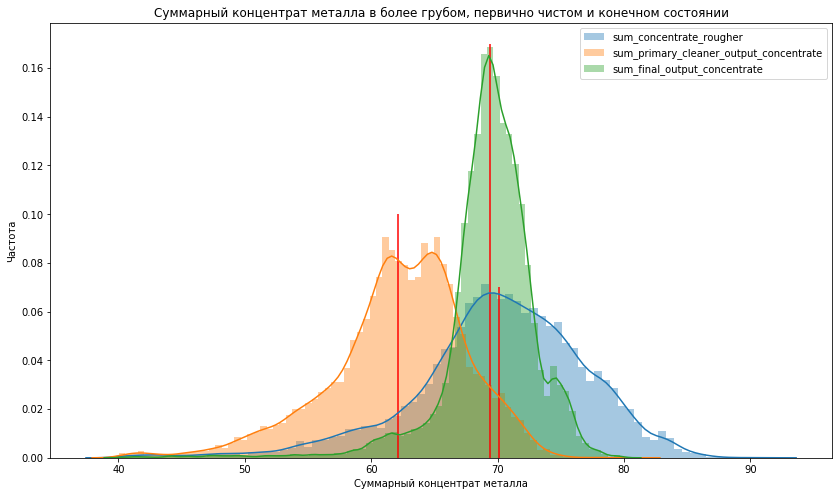

In [49]:
plt.figure(figsize=(14,8))
sns.distplot(full['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(full['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(full['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(full['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(full['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(full['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Суммарный концентрат металла в более грубом, первично чистом и конечном состоянии')
plt.xlabel("Суммарный концентрат металла")
plt.ylabel("Частота")

Убрали выбросы 40%

In [51]:
# Убираем выбросы из train суммарные концентрации, которых <40
# Считаю сумму концентраций металлов после флотации
train['sum_concentrate_rougher']=train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb']+train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au']

# Считаю сумму концентраций металлов после первичной очистки
train['sum_primary_cleaner_output_concentrate']=train['primary_cleaner.output.concentrate_ag']+train['primary_cleaner.output.concentrate_pb']+train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au']

# Считаю сумму концентраций металлов после финальной очистки
train['sum_final_output_concentrate']=train['final.output.concentrate_ag']+train['final.output.concentrate_pb']+train['final.output.concentrate_sol']+train['final.output.concentrate_au']

In [52]:
train=train[train['sum_final_output_concentrate']>40]
train=train[train['sum_primary_cleaner_output_concentrate']>40]
train=train[train['sum_concentrate_rougher']>40]
train=train.reset_index()
train.head()

,index,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667


Text(0, 0.5, 'Частота')

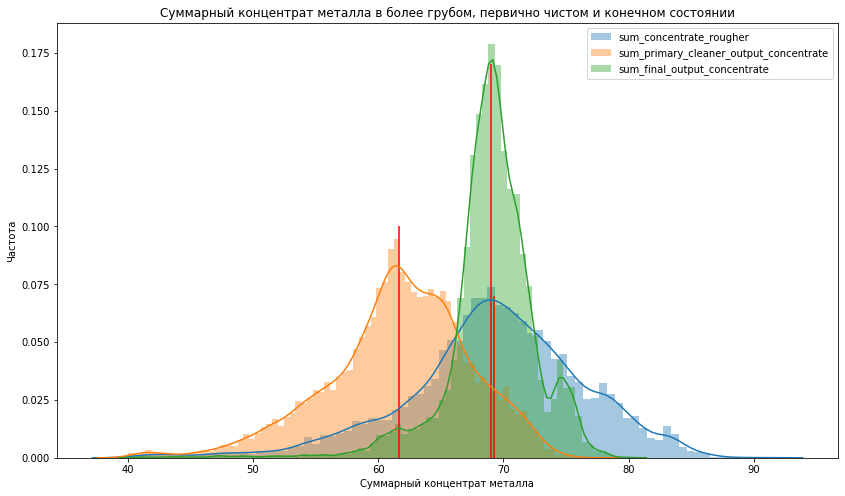

In [53]:
plt.figure(figsize=(14,8))
sns.distplot(train['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(train['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(train['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(train['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(train['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(train['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Суммарный концентрат металла в более грубом, первично чистом и конечном состоянии')
plt.xlabel('Суммарный концентрат металла')
plt.ylabel('Частота')

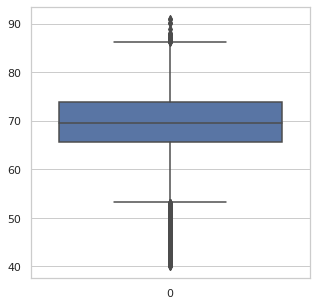

In [54]:
plt.figure(figsize=(5,5))
b=sns.set(style="whitegrid")
b=sns.boxplot(data=train['sum_concentrate_rougher'])

# 3. Модель

Реализуем расчет метрики sMAPE

In [55]:
# Функция метрики качества
def sMAPE(predict,target):
    predict_rougher=predict[:,0]
    target__rougher=target[:,0]
    predict_final=predict[:,1]
    target__final=target[:,1]
    
    sMAPE_rougher=np.sum(abs(target__rougher-predict_rougher)/((abs(target__rougher)+abs(predict_rougher))/2))
    

    sMAPE_rougher=sMAPE_rougher/len(target__rougher)*100
    
   
    sMAPE_final=np.sum(abs(target__final-predict_final)/((abs(target__final)+abs(predict_final))/2))
    sMAPE_final=sMAPE_final/len(target__final)*100
    
    sMAP=0.25*sMAPE_rougher+0.75*sMAPE_final
    return sMAP

In [56]:
columns=test.columns # Колонки которые в тестовой выборке

In [57]:
feature=train[columns] # Формируем признаки Выбираем из trian только те колонки, которые есть в test
feature=feature.drop(['date'],axis=1)
target=train[['rougher.output.recovery','final.output.recovery']] # Формируем вектор целевых признаков

In [58]:
target_array=np.array(target) # конвертирую в array

sample_size=int(len(target)/6)#Формирую длину датасета для кровв-валидации. Их будет 4

# Кросс-валидация Линейная регрессия
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
   
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    model_regression=LinearRegression().fit(feature_train,target_train)
    prediction_regress=model_regression.predict(feature_valid)   
    
    mae=mean_absolute_error(prediction_regress,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_regress,target_valid_arr)
    smape_score.append(smape)
    
    #print(mae_score)

print(np.mean(mae_score))
print(np.mean(smape_score))

5.58188903572917
8.77465128364495


In [59]:
# Кросс-валидация Случайный лес
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    for i in range(1,5,1):
        
        model_forest=RandomForestRegressor(random_state=1234,max_depth=i,n_estimators=10).fit(feature_train,target_train)
        prediction_forest=model_forest.predict(feature_valid)
        mae=mean_absolute_error(prediction_forest,target_valid)
        mae_score.append(mae)
        smape=sMAPE(prediction_forest,target_valid_arr)
        smape_score.append(smape)
        
        print('max_depth:',i,'MAE:',np.mean(mae_score))
        print('max_depth:',i,'sMAPE:',np.mean(smape_score))

max_depth: 1 MAE: 5.871229854857809
max_depth: 1 sMAPE: 9.575119425416645
max_depth: 2 MAE: 5.7968541990577105
max_depth: 2 sMAPE: 9.463395750464136
max_depth: 3 MAE: 5.743253293526247
max_depth: 3 sMAPE: 9.36934539203887
max_depth: 4 MAE: 5.765209169918857
max_depth: 4 sMAPE: 9.375247494053013
max_depth: 1 MAE: 5.920371878771364
max_depth: 1 sMAPE: 9.251927236026726
max_depth: 2 MAE: 5.9462653796603115
max_depth: 2 sMAPE: 9.073613272618418
max_depth: 3 MAE: 5.928221280868631
max_depth: 3 sMAPE: 8.918702995711007
max_depth: 4 MAE: 5.904539443753714
max_depth: 4 sMAPE: 8.819628658561108
max_depth: 1 MAE: 5.873948816317043
max_depth: 1 sMAPE: 8.726641283030954
max_depth: 2 MAE: 5.840353214930718
max_depth: 2 sMAPE: 8.643439046139996
max_depth: 3 MAE: 5.84976020231868
max_depth: 3 sMAPE: 8.608523227480706
max_depth: 4 MAE: 5.836080257092282
max_depth: 4 sMAPE: 8.560473784022438
max_depth: 1 MAE: 5.90876108580015
max_depth: 1 sMAPE: 8.780426099947622
max_depth: 2 MAE: 5.9166488326164215
ma

In [60]:
# берем значение max_depth=3 и n_estimators=5
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
        
    model_forest=RandomForestRegressor(random_state=1234,max_depth=3,n_estimators=5).fit(feature_train,target_train)
    prediction_forest=model_forest.predict(feature_valid)
    mae=mean_absolute_error(prediction_forest,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_forest,target_valid_arr)
    smape_score.append(smape)
        
print('MAE:',np.mean(mae_score))
print('sMAPE:',np.mean(smape_score))

MAE: 5.57417936845608
sMAPE: 8.242719280254388


In [61]:
# Кросс-валидация для LinearSVR
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    target_train_1=target_train.iloc[:,0]
    target_train_2=target_train.iloc[:,1]
    
    #target_valid_1['rougher.output.recovery']=target_valid['rougher.output.recovery']
    #target_valid_2['final.output.recovery']=target_valid['final.output.recovery']
    
    
    model_regressionSVR_1=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
    intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
    random_state=0, tol=1e-05, verbose=0).fit(feature_train,target_train_1)
    prediction_regressSVR_rouger=model_regressionSVR_1.predict(feature_valid)   
    
    model_regressionSVR_2=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
    intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
    random_state=0, tol=1e-05, verbose=0).fit(feature_train,target_train_2)
    prediction_regressSVR_final=model_regressionSVR_2.predict(feature_valid)   
    
    #mae=mean_absolute_error(prediction_regressSVR_2,target_valid['rougher.output.recovery'])
    #mae_score.append(mae)
    
    prediction_regressSVR=pd.DataFrame(prediction_regressSVR_rouger)
    prediction_regressSVR['final.output.recovery']=pd.DataFrame(prediction_regressSVR_final)
    prediction_regressSVR.set_axis(['rougher.output.recovery','final.output.recovery'],axis='columns',inplace=True)
    prediction_regressSVR=np.array(prediction_regressSVR)
    smape=sMAPE(prediction_regressSVR,target_valid_arr)
    smape_score.append(smape)
    
    #print(mae_score)

#print(np.mean(mae_score))
print(np.mean(smape_score))

22.77285819229314


### Предсказания на тестовом наборе данных

In [62]:
target=full[['date','rougher.output.recovery','final.output.recovery']]

test=test.merge(target,on=['date'],how='left')

test=test.dropna()

target=test[['rougher.output.recovery','final.output.recovery']]

feature=test.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)

prediction_reg=model_regression.predict(feature)

smape_line=sMAPE(prediction_reg,np.array(target))
smape_line

7.093395134845503

In [63]:
prediction_forest=model_forest.predict(feature)

smape_forest=sMAPE(prediction_forest,np.array(target))
smape_forest

7.445634095874103

In [64]:
prediction_regressSVR_rouger=model_regressionSVR_1.predict(feature) 
prediction_regressSVR_final=model_regressionSVR_2.predict(feature)

In [65]:
prediction_regressSVR=pd.DataFrame(prediction_regressSVR_rouger)
prediction_regressSVR['final.output.recovery']=pd.DataFrame(prediction_regressSVR_final)
prediction_regressSVR.set_axis(['rougher.output.recovery','final.output.recovery'],axis='columns',inplace=True)
prediction_regressSVR=np.array(prediction_regressSVR)

smape_line_svr=sMAPE(prediction_regressSVR,np.array(target))
smape_line_svr

7.0384879408686345

## ВЫВОД

In [66]:
models=['LinearRegression','RandomForestRegressor','LinearSVR']

In [67]:
sMAPE_rezult=pd.DataFrame(np.array([smape_line,smape_forest,smape_line_svr]),index=models)
sMAPE_rezult.set_axis(['sMAPE'],axis='columns',inplace=True)
sMAPE_rezult

,sMAPE
LinearRegression,7.093395
RandomForestRegressor,7.445634
LinearSVR,7.038488


По сводной таблице видно, что лучше всего себя показала модель LinearSVR=7.038488. Возможно если удалить аномалии из test то sMAPE будут лучше, но я не согласен, что их надо удалять, т.к получается, что мы специально подгоняем тестовую выборку для хорошего результата.